# QC script to calculate sharpness metric for images in a plate

The following script will access the IDR images in a facility manager's context,

The QC script does the following,

1. Extracts Images from OMERO (in this case IDR)
2. Calculates sharpness based on the algorithm defined in the following publication,
  * [Image Sharpness Measure for Blurred Images in Frequency Domain](https://doi.org/10.1016/j.proeng.2013.09.086)
3. Creates a numpy array of the sharpness scores for every well, 
  * seperately for every field and every channel
  * the numpy array is then reshaped to the same dimensions of the plate, ex: 96 well plates will have a numpy array 
    with 8rows and 12columns.
4. Plots a heatmap for every field and every channel, and arranges all plots within a subplot.
5. Exports the heatmap back to OMERO in the following ways,
  * Saves the ["plate_name" + "heatmap.png"] and attaches it to the appropriate plate as a file attachment.
  * Saves the numpy array as an image back to OMERO and a secondary script "createOMEROFigures" can be used to create 
    figures in OMERO.figures in the same layout as seen in the ["plate_name" + "heatmap.png"]

# Workflow summary

![Overview](../includes/PlateToHeatmap.jpg)

***Import Packages***

In [58]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import decimal
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import array, int8
from skimage import feature
from scipy.ndimage import convolve
from scipy import misc, fftpack

***Import BlitzGateway***

In [59]:
from omero.gateway import BlitzGateway

***Create connection and plate identifier***

In [60]:
USERNAME = ''
PASSWORD = ''
HOST = ''
PORT = 4064
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT)
conn.connect()
plateId = 408
print conn

Connected to IDR...


***Fetch plate object and print details***

In [61]:
plate = conn.getObject("Plate", plateId)
print "\nNumber of fields:", plate.getNumberOfFields()
print "\nGrid size:", plate.getGridSize()
print "\nWells in Plate:", plate.getName()

plate_rows = plate.getRows()
plate_columns = plate.getColumns()
plate_format = plate_rows * plate_columns

print "\nPlate Format:", plate_format


Number of fields: (0L, 0L)

Grid size: {'rows': 16L, 'columns': 24L}

Wells in Plate: 0001-03--2005-08-01

Plate Format: 384


***Alogrithm List***

In [62]:
class AlgorithmList:
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (M/float(1000))).sum()
        if 'image' in locals():
            sharpness = Th/(float(image.getSizeX())*float(image.getSizeY()))
            return sharpness*10000
        else:
            return Th
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness
    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness = sharpness[edges1 != 0].sum()
        return sharpness
print "loaded:", dir(AlgorithmList)

loaded: ['__doc__', '__module__', 'edgeBasedSharpnessMetric', 'fourierBasedSharpnessMetric', 'gradientBasedSharpnessMetric']


***Test your algorithm on example data***

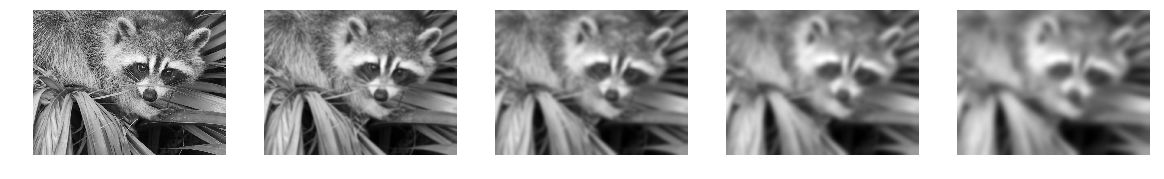

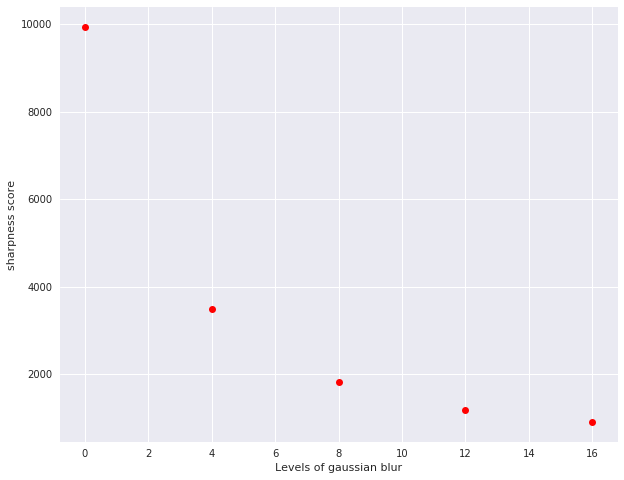

In [65]:
import scipy as sp
from scipy import misc
from scipy import ndimage

resultArray = np.zeros((5, 2), dtype=float);
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in xrange(0,20,4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(face, sigma=sigValue)
    plt.subplot(1,5,cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = AlgorithmList().fourierBasedSharpnessMetric();
    resultArray[cntr-1,1] = sharpness
    resultArray[cntr-1,0] = sigValue
    cntr= cntr + 1

plt.show()
plt.figure(figsize=(10, 8))
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.xlabel('Levels of gaussian blur')
plt.ylabel('sharpness score')
plt.show()

plt.gcf().clear()

***Test your algorithm on plate data***

0001-03--2005-08-01 [Well 125, Field 1 (Spot 125)] 


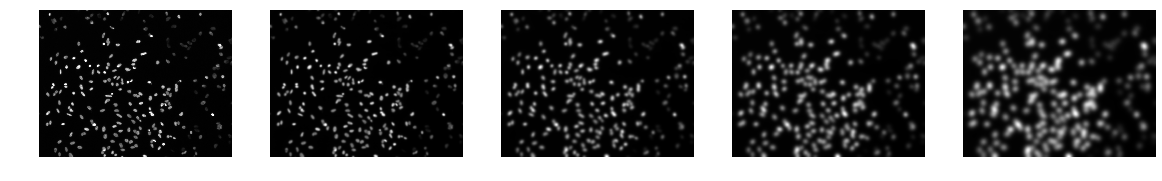

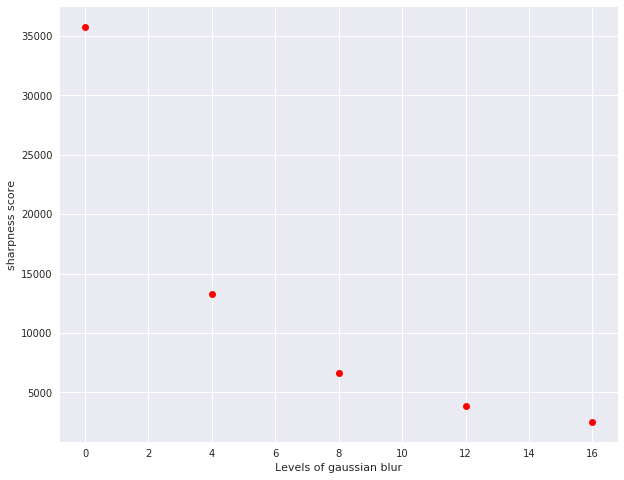

In [66]:
imageId = 171499
image = conn.getObject("Image", imageId)
print image.getName(), image.getDescription()

pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

resultArray = np.zeros((5, 2), dtype=float);
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in xrange(0,20,4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(image_plane, sigma=sigValue)
    plt.subplot(1,5,cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = AlgorithmList().fourierBasedSharpnessMetric();
    resultArray[cntr-1,1] = sharpness
    resultArray[cntr-1,0] = sigValue
    cntr = cntr + 1
plt.show()
plt.figure(figsize=(10, 8))
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.xlabel('Levels of gaussian blur')
plt.ylabel('sharpness score')
plt.show()
plt.gcf().clear() 

***Iterative calculations for the whole plate***

In [45]:
chnames = None
cntr = 0
fields = 0
size_z = fields
for well in plate.listChildren():
    index = well.countWellSample()
    image = well.getImage(fields)
    if chnames is None:
        chnames = [ch.getLabel() for ch in image.getChannels(True)]
    pixels = image.getPrimaryPixels()
    size_c = image.getSizeC();
    if cntr==0:
        result_array = np.zeros((plate_format, size_c), dtype=float);
    for ch in xrange(0, size_c):
        plane = pixels.getPlane(0, ch, 0)
        sharpness = AlgorithmList().fourierBasedSharpnessMetric()
        result_array[((well.row) * plate_columns) + well.column, ch] = sharpness
        tempvalue = result_array[((well.row) * plate_columns) + well.column, ch]
        wellid = ((well.row) * plate_columns) + well.column
        fieldid = (fields + ch * size_c)
        cntr = cntr + 1
        print "  Well: ", well.row, well.column, " Fields:", index , " Channels:", ch, " SharpnessScore:", sharpness

  Well:  7 3  Fields: 1  Channels: 0  SharpnessScore: 20369
  Well:  7 3  Fields: 1  Channels: 1  SharpnessScore: 22433
  Well:  7 3  Fields: 1  Channels: 2  SharpnessScore: 31995
  Well:  8 5  Fields: 1  Channels: 0  SharpnessScore: 20267
  Well:  8 5  Fields: 1  Channels: 1  SharpnessScore: 19747
  Well:  8 5  Fields: 1  Channels: 2  SharpnessScore: 27795
  Well:  9 0  Fields: 1  Channels: 0  SharpnessScore: 21521
  Well:  9 0  Fields: 1  Channels: 1  SharpnessScore: 22455
  Well:  9 0  Fields: 1  Channels: 2  SharpnessScore: 36115
  Well:  10 7  Fields: 1  Channels: 0  SharpnessScore: 22881
  Well:  10 7  Fields: 1  Channels: 1  SharpnessScore: 23781
  Well:  10 7  Fields: 1  Channels: 2  SharpnessScore: 35821
  Well:  11 22  Fields: 1  Channels: 0  SharpnessScore: 23159
  Well:  11 22  Fields: 1  Channels: 1  SharpnessScore: 18513
  Well:  11 22  Fields: 1  Channels: 2  SharpnessScore: 33245
  Well:  0 17  Fields: 1  Channels: 0  SharpnessScore: 217458
  Well:  0 17  Fields: 1  Cha

***Reshape numpy array and plot heatmaps***

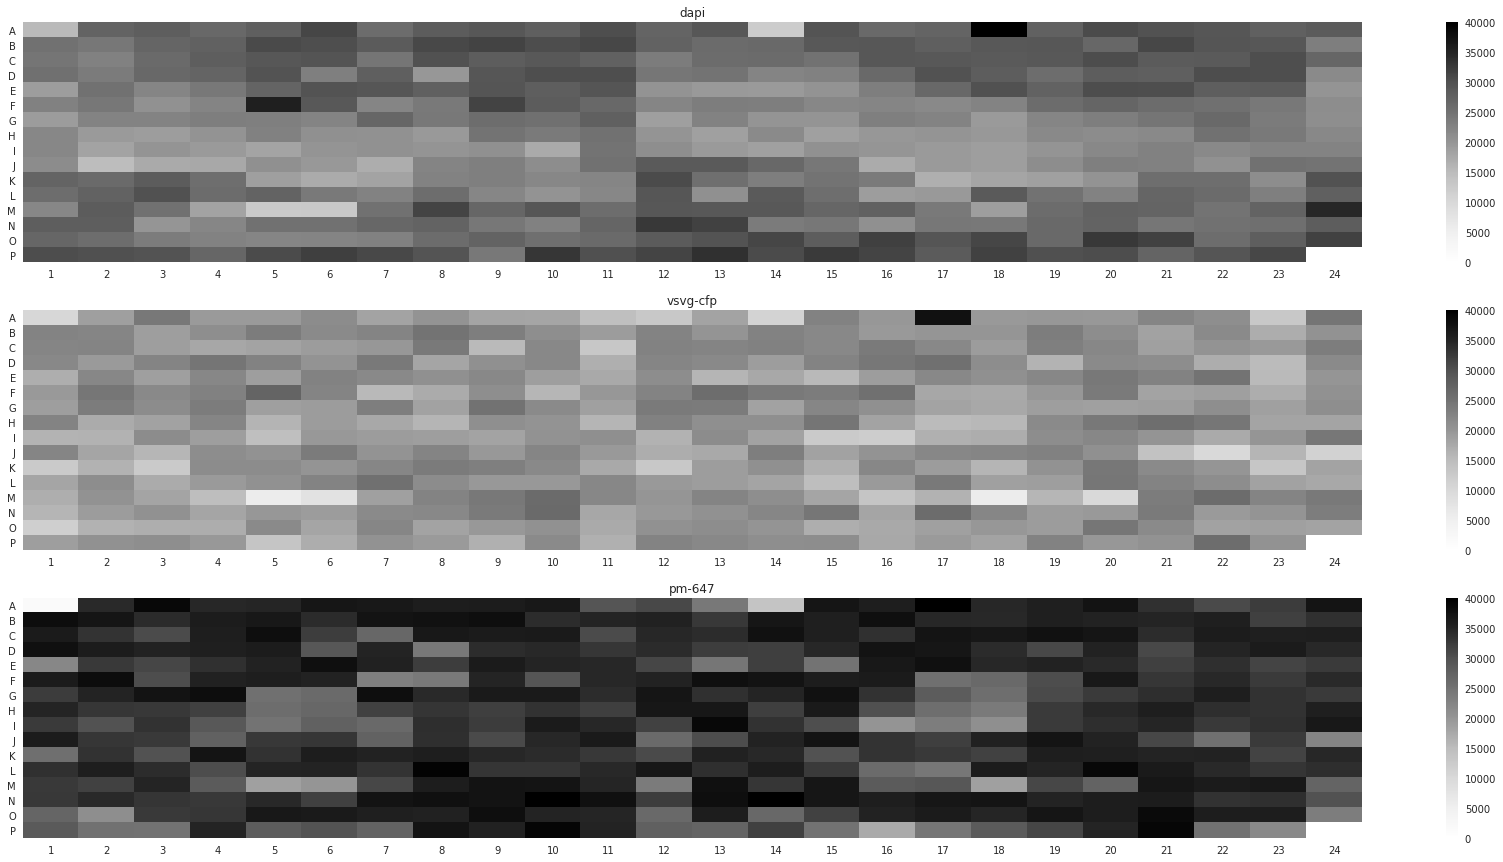

In [67]:
import string

alphabets = list(string.ascii_uppercase)
plate_name = plate.getName()
colval = 0
planes = []
cntr = 0
size_c = 3
fig = plt.figure(figsize=(30, 15))
for rowval in range (0, size_c):
    data = result_array[:, rowval].reshape(plate_rows, plate_columns);
    ax = plt.subplot(size_c,1,cntr+1)
    plt.pcolor(data)
    plt.colorbar()
    ax.title.set_text(chnames[rowval])
    plt.xticks(np.arange(0.5, plate_columns, 1.0))
    plt.yticks(np.arange(0.5, plate_rows, 1.0))
    xlabels = range(1, plate_columns+1) 
    ax.set_xticklabels(xlabels)
    ylabels = range(1, plate_rows+1)
    ax.set_yticklabels([alphabets[i-1] for i in ylabels])
    plt.gca().invert_yaxis()
    plt.clim(0,40000)

    data = np.repeat(data, 20, axis=1)
    data = np.repeat(data, 20, axis=0)
    planes.append(np.uint16(data))
    cntr = cntr + 1

plt.show()
fig.savefig(plate_name + 'SharpnessHeatMaps.png')

***Thumbnails of top2 and bottom 2 percentile images***

In [68]:
import pandas as pd

mapAnnotationNameSpace = "openmicroscopy.org/mapr/gene"
bulkAnnotationNameSpace = "openmicroscopy.org/omero/bulk_annotations"
def id_to_image_html(id):
    return '<img src="http://idr.openmicroscopy.org/webclient/render_thumbnail/%d/"/>' % id

def getGeneInformation(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(mapAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows: 
        if r[1].startswith("http"):
            tempvar = "<a href='"+ r[1] + "'>" + r[1] + "</a>"
        else:
            tempvar = r[1]
        html.append("<tr><td>" + tempvar + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")

def getQualityControl(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(bulkAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows:
        if r[0].startswith('Control') or r[0].startswith('Quality'):
            html.append("<tr><td>" + r[1] + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")

from StringIO import StringIO
from IPython.display import Image, HTML, display

fields = 0
ch = 2
threshold = np.percentile(result_array[:, ch], 2)
imageList = []
for well in plate.listChildren():
    
    row = well.row
    column = well.column
    sharpness = result_array[((row)*plate_columns) + column, ch]
    
    if (sharpness <= threshold):       
        image = well.getImage(fields)
        imageList.append(image)

images = [(x.id, x.id, x.getName(), x, x) for x in (imageList)]
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame(images, columns = ['Id', 'Image', 'Name', 'GeneInformation', 'QualityControl'])
HTML(df.to_html(escape=False, formatters=dict(Image=id_to_image_html, GeneInformation=getGeneInformation, QualityControl=getQualityControl)))

In [69]:
import pandas as pd

mapAnnotationNameSpace = "openmicroscopy.org/mapr/gene"
bulkAnnotationNameSpace = "openmicroscopy.org/omero/bulk_annotations"
def id_to_image_html(id):
    return '<img src="http://idr.openmicroscopy.org/webclient/render_thumbnail/%d/"/>' % id

def getGeneInformation(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(mapAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows: 
        if r[1].startswith("http"):
            tempvar = "<a href='"+ r[1] + "'>" + r[1] + "</a>"
        else:
            tempvar = r[1]
        html.append("<tr><td>" + tempvar + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")

def getQualityControl(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(bulkAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows:
        if r[0].startswith('Control') or r[0].startswith('Quality'):
            html.append("<tr><td>" + r[1] + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")

from StringIO import StringIO
from IPython.display import Image, HTML, display

fields = 0
ch = 2
threshold = np.percentile(result_array[:, ch], 98)
imageList = []
for well in plate.listChildren():
    
    row = well.row
    column = well.column
    sharpness = result_array[((row)*plate_columns) + column, ch]
    
    if (sharpness >= threshold):       
        image = well.getImage(fields)
        imageList.append(image)

images = [(x.id, x.id, x.getName(), x, x) for x in (imageList)]
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame(images, columns = ['Id', 'Image', 'Name', 'GeneInformation', 'QualityControl'])
HTML(df.to_html(escape=False, formatters=dict(Image=id_to_image_html, GeneInformation=getGeneInformation, QualityControl=getQualityControl)))

***Save Results Back to OMERO as File Attachments (writing back to a read-write server)***

In [74]:
plate = conn.getObject("Plate", plateId)
file_to_upload = plate_name + 'SharpnessHeatMaps.png'   # This file should already exist
# create the original file and file annotation (uploads the file etc.)
namespace = "dundee.users.meeting.demo"
print "\nCreating an OriginalFile and FileAnnotation"
file_ann = conn.createFileAnnfromLocalFile(
    file_to_upload, mimetype="text/plain", ns=namespace, desc=None)
print "Attaching FileAnnotation to Plate: ", "File ID:", file_ann.getId(), \
    ",", file_ann.getFile().getName(), "Size:", file_ann.getFile().getSize()
plate.linkAnnotation(file_ann)


Creating an OriginalFile and FileAnnotation
Attaching FileAnnotation to Plate:  File ID: 7328034 , 0001-03--2005-08-01SharpnessHeatMaps.png Size: 59569


<FileAnnotationWrapper id=7328034>

***Create OMERO Image from numpy sequence, feeder for createOMEROFigures script****

In [72]:
size_z = 1
size_t = 1
def planeGen():
    """generator will yield planes"""
    for p in planes:
        yield p

desc = "Image created from a hard-coded arrays"
i = conn.createImageFromNumpySeq(planeGen(), plate_name + "numpy image", size_z, size_c, size_t, description=desc,dataset=None)
print 'Created new Image:%s Name:"%s"' % (i.getId(), i.getName())

Created new Image:3126556 Name:"0001-03--2005-08-01numpy image"


***Close Connection***

In [59]:
conn.close()